#### **Importing the Library**

In [51]:
# The basic library for data analysis and visulaization
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":20,"axes.labelsize":14})   

In [52]:
#Importing the wordToVec Packages
import gensim
from gensim.utils import simple_preprocess
# model for word embedding
model = gensim.models.KeyedVectors.load_word2vec_format(
    '/content/drive/MyDrive/BrainStation/lexvec.enwiki+newscrawl.300d.W.pos.vectors', binary=False
)

In [53]:
# sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [54]:
# NLP library
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize, pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [55]:
# Remove words that are  two or less characters and Lemmatize all words in documents.
def docs_preprocessor(doc):
    tokenizer = RegexpTokenizer(r'\w+')
    docs = tokenizer.tokenize(doc) 
    docs = [token for token in docs if len(token) > 3]
    lemmatizer = WordNetLemmatizer()
    docs = [lemmatizer.lemmatize(token) for token in docs]
    docs= " ".join(docs)
    return docs

In [56]:
 #Extract nouns adjective and verb to create a new pos document 
def extract_nouns_adj_vrb(text):
    is_noun = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ' or  pos[:2]=='VB'
    tokenizer = RegexpTokenizer(r'\w+')
    docs = tokenizer.tokenize(text) 
    all_nouns = [word for (word, pos) in pos_tag(docs) if is_noun(pos)] 
    return ' '.join(all_nouns)

####**Loading the Data**

In [57]:
# loading the Training data 
df_train= pd.read_pickle("/content/drive/MyDrive/BrainStation/df_tweet_train.pkl")
print(f'The training set contains {df_train.shape[0]} user profile as rows and {df_train.shape[1]} features ')

The training set contains 815 user profile as rows and 14 features 


In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 815 entries, 0 to 814
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   user_name                    815 non-null    object 
 1   text_document                815 non-null    object 
 2   avg_word_count_per_week      815 non-null    float64
 3   total_tw_morning             815 non-null    int64  
 4   total_twt_afternoon          815 non-null    int64  
 5   total_twt_evening            815 non-null    int64  
 6   total_twt_night              815 non-null    int64  
 7   avg_emoji_wordcount_ratio    815 non-null    float64
 8   avg_usertag_wordcount_ratio  815 non-null    float64
 9   avg_hashtag_wordcount_ratio  815 non-null    float64
 10  twt_profanity_score          815 non-null    float64
 11  twt_polarity_score           815 non-null    float64
 12  emoji_polarity_score         815 non-null    float64
 13  lemmatized_texts    

###**Embedding Text Documents**

####**Creating the new corpus based on the functions of a word in a sentence**

In [59]:
# extracting the text document , the user name  and avg_word_count_per_week from the  dataset
text_documents = df_train[['user_name','text_document',"avg_word_count_per_week"]]
text_documents.reset_index(inplace=True)
text_documents.rename(columns={"index":"old_index"},inplace=True)
text_documents.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,old_index,user_name,text_document,avg_word_count_per_week
0,0,pretagil,pronta para o womensmusicevent styling marcell...,14.000000
1,1,mirzasania,it took seconds to watch this in that time ano...,17.564706
2,2,parishilton,totally fan girling despite having met many we...,52.633333
3,3,piersmorgan,rt icymi catch up with this week s episodes of...,66.821429
4,4,timtebow,thank you accomplish the mission that you have...,24.500000


In [60]:
# Exploring the central tendency of the avg_word_count_per_week feature
text_documents.describe()

,old_index,avg_word_count_per_week
count,815.000000,815.000000
mean,407.000000,18.597252
std,235.414528,14.781978
min,0.000000,1.000000
25%,203.500000,12.070137
50%,407.000000,16.583333
75%,610.500000,21.005952
max,814.000000,175.466667


In [61]:
# Preprocessing the text document and Calcualting the new feature of document length(number of words )
text_documents["document_pos"]=text_documents["text_document"].map(lambda x: extract_nouns_adj_vrb(x))
text_documents["document_lem"]=text_documents["document_pos"].map(lambda x: docs_preprocessor(x))
text_documents["document_length"]=text_documents["document_lem"].map(lambda x: len(x.split(" ")))
text_documents.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,old_index,user_name,text_document,avg_word_count_per_week,document_pos,document_lem,document_length
0,0,pretagil,pronta para o womensmusicevent styling marcell...,14.000000,pronta para o womensmusicevent styling marcell...,pronta para womensmusicevent styling marcellma...,11
1,1,mirzasania,it took seconds to watch this in that time ano...,17.564706,took seconds watch time girl became child brid...,took second watch time girl became child bride...,661
2,2,parishilton,totally fan girling despite having met many we...,52.633333,fan girling having met many known individuals ...,girling having many known individual happy ser...,658
3,3,piersmorgan,rt icymi catch up with this week s episodes of...,66.821429,rt icymi catch week s episodes piers morgan un...,icymi catch week episode pier morgan uncensore...,818
4,4,timtebow,thank you accomplish the mission that you have...,24.500000,thank accomplish mission have been called equi...,thank accomplish mission have been called equi...,965


####**Exploring the threshold for Padding and Clipping for the text document**

In [62]:
# Dropping the user data where avg_word_count_per_week is below the 25% percentile of the overall trend 

#  Calculating the 25% of the overall trend in avg_word_count_per_week
cutoff = np.percentile(text_documents["avg_word_count_per_week"], 25)

# Filtering the document based on above threshold
text_documents_filtered = text_documents[(text_documents["avg_word_count_per_week"]>cutoff)]
text_documents_filtered.shape

(611, 7)

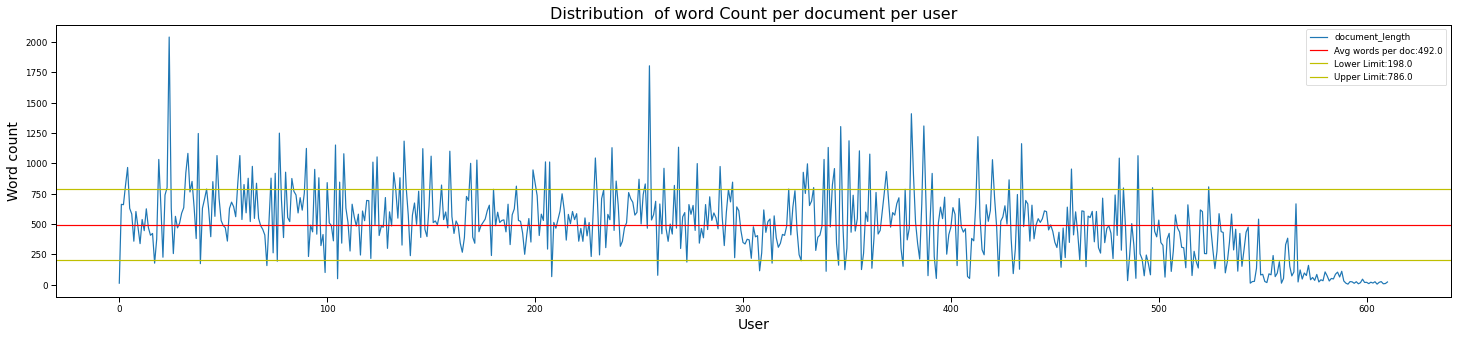

In [63]:
# Visualizing the distribution of word count across all users 
mean = round(text_documents_filtered["document_length"].mean(),0)
std = round(text_documents_filtered["document_length"].std(),0)
text_documents_filtered.reset_index(inplace=True)
text_documents_filtered["document_length"].plot(figsize=(25,5))
plt.axhline(mean,color ="r" ,label=f'Avg words per doc:{mean}')
plt.axhline(mean-std,color ="y" ,label=f'Lower Limit:{mean-std}')
plt.axhline(mean+std,color ="y" ,label=f'Upper Limit:{mean+std}')
plt.title("Distribution  of word Count per document per user",fontsize=16)
plt.xlabel("User")
plt.ylabel("Word count")
plt.legend()
plt.show()


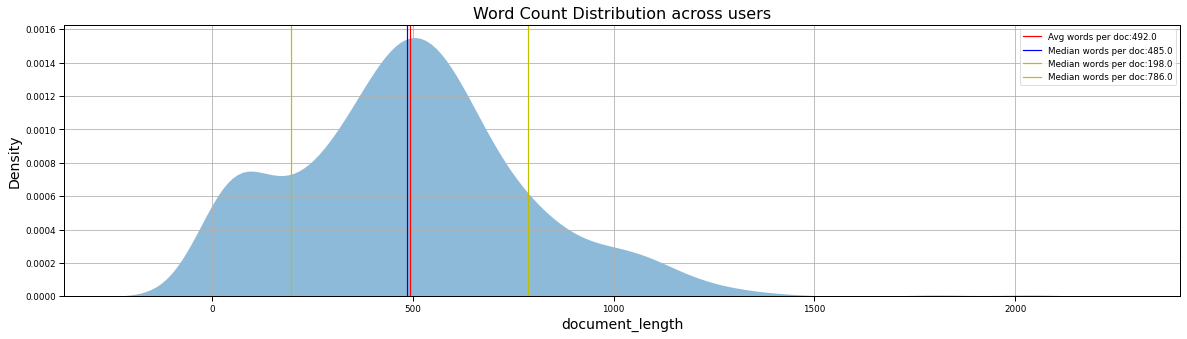

In [64]:

# Analyzing the appropriate length for document before embedding  
mean = round(text_documents_filtered["document_length"].mean(),0)
median = round(text_documents_filtered["document_length"].median(),0)
std = round(text_documents_filtered["document_length"].std(),0)
plt.figure(figsize=(20,5))
sns.kdeplot(
   data=text_documents_filtered, x="document_length", 
   fill=True,  palette="crest",
   alpha=.5, linewidth=0,
)
plt.axvline(mean,color ="r" ,label=f'Avg words per doc:{mean}')
plt.axvline(median,color ="b" ,label=f'Median words per doc:{median}')
plt.axvline(mean-std,color ="y" ,label=f'Median words per doc:{mean-std}')
plt.axvline(mean+std,color ="y" ,label=f'Median words per doc:{mean+std}')
plt.title("Word Count Distribution across users",fontsize=16)
plt.grid()
plt.legend()
plt.show()


Based on the above density plot and the line plot, the mean value of `494` words per document is considered as the standard size of the document .Any document where the word count  is below the mean value are padded with 0  upto the mean value and the document where the word count is more than the mean value is clipped down to the mean value.  <br/>

**Note:**<br/>
In the cases for clipping, the latest tweet are considered and the older text are dropped as needed.


####**Converting the Text Document into multi-dimenisonal Vector using word2vec**

In [65]:
# Converting the text to into a matrix of numbers based upon the level of semantic similarity
def sentence2vec(text,threshold):
    tokenized = simple_preprocess(text)
    word_embeddings = []
    for word in tokenized:
      # if the word is in the model then embed
      if word in model:
        vector = model[word]
      # add zeros for out-of-vocab words
      else:
        vector = np.zeros(300)
      word_embeddings.append(vector)
    # cliping the  array
    if(len(word_embeddings)>=threshold):
      # Keeping the latest text tweets  and clipping the  older tweets
      word_embeddings=word_embeddings[-threshold:]
    else:
      # padding the array
      length =len(tokenized)
      word_embeddings = word_embeddings+[np.zeros(300)]*(threshold-length)

    sentence_embedding = np.stack(word_embeddings[:threshold])
    return sentence_embedding

In [66]:
# Coverting the text document using wordtovec and applying padding and clipping based upon the median value as threshold 
threshold =int( round(text_documents_filtered["document_length"].mean(),0))

text_documents_filtered["document_token"]= text_documents_filtered.loc[:,"document_lem"].map(lambda x:sentence2vec(x,threshold)).copy()
text_documents_filtered.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,index,old_index,user_name,text_document,avg_word_count_per_week,document_pos,document_lem,document_length,document_token
0,0,0,pretagil,pronta para o womensmusicevent styling marcell...,14.000000,pronta para o womensmusicevent styling marcell...,pronta para womensmusicevent styling marcellma...,11,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,1,mirzasania,it took seconds to watch this in that time ano...,17.564706,took seconds watch time girl became child brid...,took second watch time girl became child bride...,661,"[[0.13143600523471832, 0.007573000155389309, 0..."
2,2,2,parishilton,totally fan girling despite having met many we...,52.633333,fan girling having met many known individuals ...,girling having many known individual happy ser...,658,"[[0.0372840017080307, 0.26623600721359253, -0...."
3,3,3,piersmorgan,rt icymi catch up with this week s episodes of...,66.821429,rt icymi catch week s episodes piers morgan un...,icymi catch week episode pier morgan uncensore...,818,"[[0.062196001410484314, -0.00609700009226799, ..."
4,4,4,timtebow,thank you accomplish the mission that you have...,24.500000,thank accomplish mission have been called equi...,thank accomplish mission have been called equi...,965,"[[-0.05783800035715103, -0.10095900297164917, ..."


###**Reshaping the multi-dimenisonal Vector and converting into Text level features** 

In [67]:
# reshaping the document_token column 
text_documents_filtered["document_token_re"]= text_documents_filtered["document_token"].apply(lambda x :x.reshape(threshold*300))

# Split a Pandas column of lists into multiple columns
df = pd.DataFrame (text_documents_filtered["document_token_re"].to_list())
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,0,1,2,3,4,5,6,7,8,9,...,147590,147591,147592,147593,147594,147595,147596,147597,147598,147599
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.131436,0.007573,0.293627,-0.151418,-0.039667,0.007688,-0.168641,-0.126157,0.053723,-0.038319,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.037284,0.266236,-0.177273,-0.000795,-0.228873,0.125547,-0.069322,0.161116,-0.077844,0.110592,...,-0.027703,0.057849,-0.009585,-0.024870,-0.097929,0.139356,0.052240,-0.000128,-0.058629,-0.057176
3,0.062196,-0.006097,-0.007706,0.011647,0.155652,-0.059457,-0.026771,-0.084850,0.057227,-0.083734,...,-0.161023,0.131608,-0.008456,-0.367710,-0.078529,-0.162835,-0.052445,0.134085,-0.202317,-0.083041
4,-0.057838,-0.100959,-0.073216,0.059703,0.194651,0.090772,0.031257,0.055684,-0.012021,-0.215497,...,0.251591,-0.031324,-0.093769,-0.154632,0.193099,0.061407,-0.074184,0.006405,-0.037542,0.016034


In [68]:
# adding the dataframe with the username for the text level feature matrix
text_level_feature = df
text_level_feature.index = text_documents_filtered["user_name"]
text_level_feature.shape
print(f"The Text Level feature matrix contains {df.shape[0]} rows and {df.shape[1]} features")

The Text Level feature matrix contains 611 rows and 147600 features


###**Dimensionality Reduction using Principal Component Analysis**

In [69]:
# scaling the data
sc = StandardScaler()
df_pca = sc.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,147590,147591,147592,147593,147594,147595,147596,147597,147598,147599
0,-0.122723,-0.070555,-0.257209,0.031434,0.249684,-0.434433,0.248337,0.490743,0.030236,-0.241864,...,-0.024500,0.103281,0.212296,0.374049,0.173027,-0.221365,-0.046433,-0.018611,0.178656,0.093224
1,0.935317,-0.009573,1.815954,-1.080399,-0.059846,-0.372406,-1.067214,-0.426785,0.481644,-0.531125,...,-0.024500,0.103281,0.212296,0.374049,0.173027,-0.221365,-0.046433,-0.018611,0.178656,0.093224
2,0.177408,2.073317,-1.508851,0.025596,-1.536264,0.578493,-0.292437,1.662526,-0.623848,0.592968,...,-0.304224,0.757605,0.108384,0.121601,-0.871590,1.006667,0.556002,-0.019901,-0.474414,-0.430219
3,0.377946,-0.119651,-0.311618,0.116955,1.464273,-0.914138,0.039499,-0.126363,0.511086,-0.873952,...,-1.650389,1.591884,0.120623,-3.358467,-0.664649,-1.656299,-0.651231,1.332181,-2.074960,-0.667011
4,-0.588310,-0.883529,-0.774153,0.469821,1.768591,0.297925,0.492170,0.895728,-0.070770,-1.868599,...,2.515876,-0.251021,-0.804269,-1.195575,2.232830,0.319765,-0.901926,0.045914,-0.239525,0.240014


In [70]:
# dimensionality reduction using PCA with the 90% variance
pca = PCA(n_components=0.99)
df_pca =pca.fit_transform(df_pca)
df_pca = pd.DataFrame(df_pca)
df_pca.index = text_documents_filtered["user_name"]
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,535,536,537,538,539,540,541,542,543,544
user_name,,,,,,,,,,,,,,,,,,,,,
pretagil,77.003189,21.063501,8.027351,-11.288114,1.978597,0.900685,2.707927,-3.296990,0.481362,0.792815,...,-1.855544,-2.692478,-1.967330,-1.387492,-4.878930,-2.644886,-1.813038,-3.472745,-3.345549,-4.546941
mirzasania,-31.513505,20.314391,-25.054147,5.120905,7.746370,0.693428,1.689198,-7.482959,12.561423,-2.613535,...,-0.009054,-0.201551,0.284694,-0.037174,-0.548764,0.393224,-0.523362,-0.030972,-0.558941,-0.307214
parishilton,-44.685002,3.551867,2.355403,-19.977749,16.050379,-5.293778,-9.636480,-11.558208,-1.849363,8.245251,...,0.515333,-0.431166,-0.076479,-0.451471,0.067171,-0.053810,-0.089039,0.024853,0.177218,-0.049242
piersmorgan,-36.241084,25.436608,-14.787861,5.049787,-22.664859,-9.249491,18.773514,-20.578940,3.154399,15.675286,...,-0.011600,-0.396712,0.517587,0.328117,0.382889,0.046167,0.438251,-0.061825,0.260848,-0.321795
timtebow,-45.522537,21.213561,-28.390733,-4.885159,-2.275353,-1.020448,-17.044497,9.069185,11.204685,-22.736768,...,0.417373,-0.160224,0.647942,0.051444,-0.001043,0.254340,0.325891,0.055787,-0.045340,0.190834


In [71]:
df_pca.shape
print(f"The Text Level feature matrix after PCA contains {df.shape[0]} rows and {df.shape[1]} features")

The Text Level feature matrix after PCA contains 611 rows and 147600 features


### **Exploring and analysing the pattern between Text level and Topic level features in lower dimension**

In [72]:
# Reducing the dimension of the Text_level_feature matrix
pca = PCA(n_components=2).fit_transform(df)
text_level_pca = pd.DataFrame(pca)
text_level_pca.columns =["pc_1","pc_2"]
text_level_pca.index =df.index
text_level_pca.head()

,pc_1,pc_2
user_name,,
pretagil,9.071770,1.587068
mirzasania,-3.364695,2.618358
parishilton,-4.811870,-0.621116
piersmorgan,-3.817682,1.827155
timtebow,-4.898888,2.602334


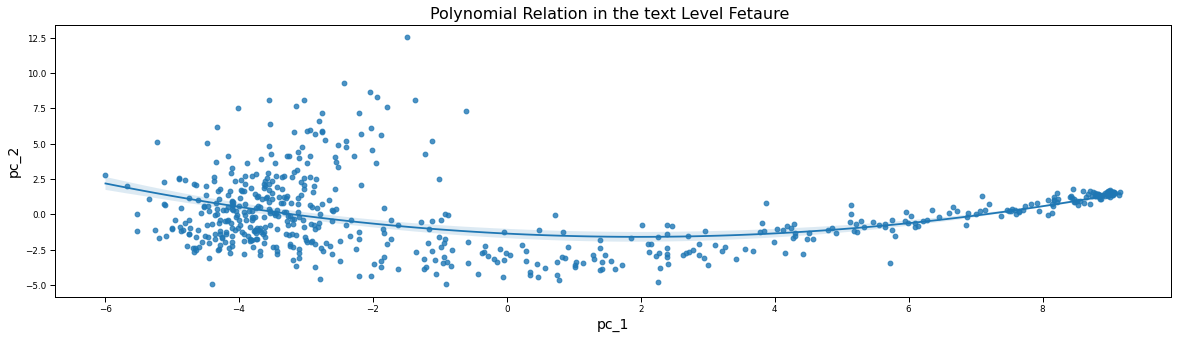

In [74]:
# Exploring and visualizing the relatability of topic level feature of the user with respect to text level feature 
plt.figure(figsize=(20,5))
sns.regplot(data =text_level_pca, x ="pc_1", y ="pc_2",order=2)
plt.title(f"Polynomial Relation in the text Level Fetaure ",fontsize =16)
plt.show()

In [75]:
#Combining the topic level feature with Text level feature
Combine_topic_text_df = pd.merge(topic_level_feature,text_level_pca,left_index=True,right_index=True)
Combine_topic_text_df.head()

,relatable,non_relatable,pc_1,pc_2
pretagil,topic_4,topic_1,9.071770,1.587068
mirzasania,topic_3,topic_5,-3.364695,2.618358
parishilton,topic_4,topic_5,-4.811870,-0.621116
piersmorgan,topic_3,topic_5,-3.817682,1.827155
timtebow,topic_2,topic_5,-4.898888,2.602334


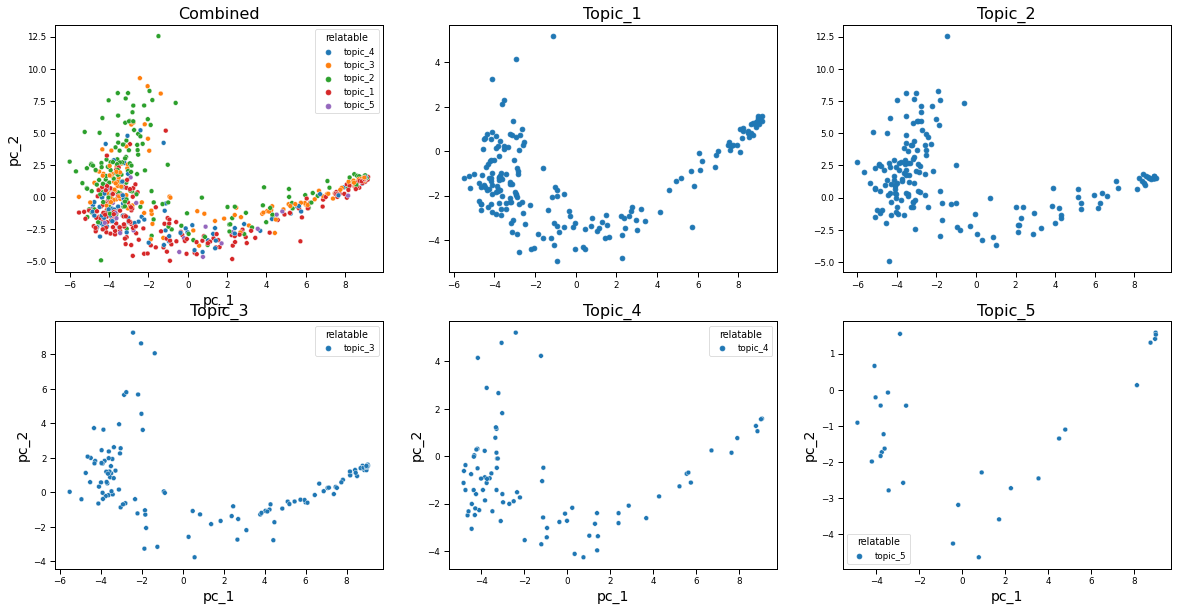

In [148]:
from operator import countOf
# Exploring and visualizing the relatability of topic level feature of the user with respect to text level feature 
plt.figure(figsize=[20,10])
for index in range(0,6):
  top = f"topic_{index}"
  df_topic_r = Combine_topic_text_df[Combine_topic_text_df["relatable"]== top]
  if index ==0:
    plt.subplot(2,3,index+1)
    sns.scatterplot(data =Combine_topic_text_df, x ="pc_1", y ="pc_2",hue="relatable")
    plt.title(f"Combined",fontsize =16)
  elif index<3:
    plt.subplot(2,3,index+1)
    plt.scatter(x =df_topic_r["pc_1"],y=df_topic_r["pc_2"])
    plt.title(f"Topic_{index}",fontsize =16)
  else:
    top = f"topic_{index}"
    df_topic_r = Combine_topic_text_df[Combine_topic_text_df["relatable"]== top]
    plt.subplot(2,3,index+1)
    sns.scatterplot(data =df_topic_r,x ="pc_1",y="pc_2", hue="relatable")
    plt.title(f"Topic_{index}",fontsize =16)

plt.show()



###**Saving Text level feature matrix for Recommander system model**

In [ ]:
# A new file is created
with open('/content/drive/MyDrive/BrainStation/text_level_feature_matrix.pkl', 'wb') as file:
    pickle.dump(text_level_feature, file)